In [4]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00:00:0100:01


In [5]:
from pathlib import Path
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import random
import torch
from tqdm import tqdm
from torch import nn

In [6]:
path = Path('/kaggle/input/airbus-ship-detection')
os.listdir(path)

['test_v2',
 'sample_submission_v2.csv',
 'train_ship_segmentations_v2.csv',
 'train_v2']

In [7]:
df = pd.read_csv(path/'train_ship_segmentations_v2.csv')
df = df.set_index('ImageId')
df.head()

EncodedPixels
ImageId                                                         
00003e153.jpg                                                NaN
0001124c7.jpg                                                NaN
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [8]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [9]:
def show_img_mask(img_id, df):
    img = cv2.imread(os.path.join(path/'train_v2', img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = get_mask(img_id, df)
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.show()

image id bfc7d2b14.jpg


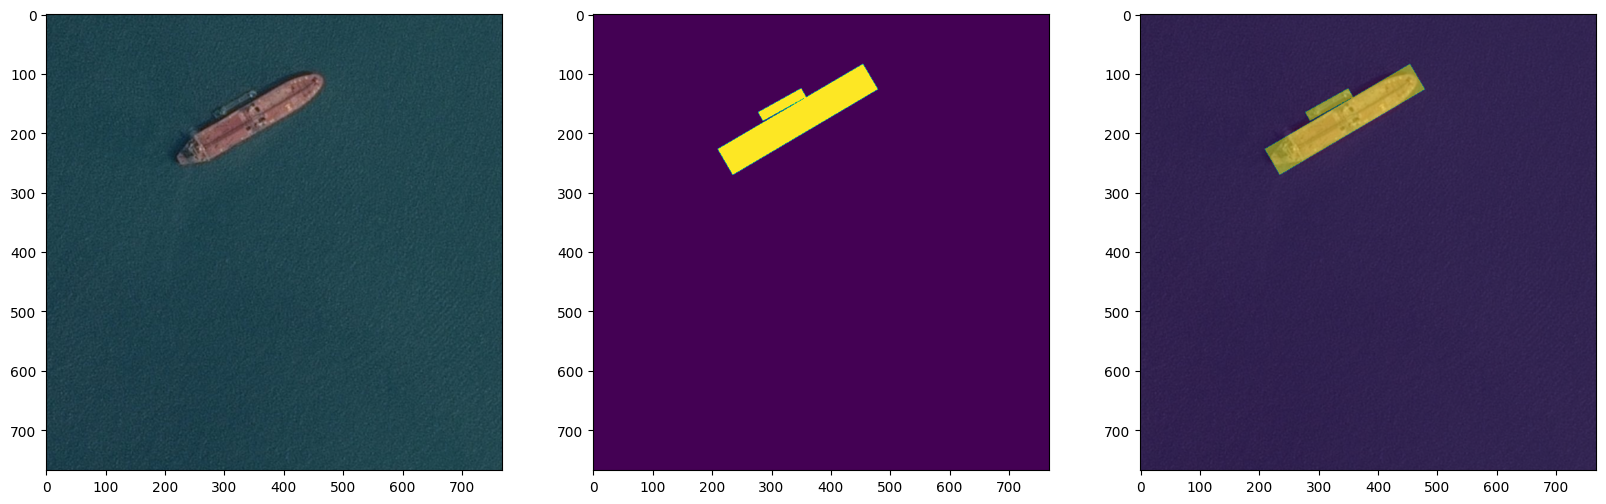

In [10]:
img_id = random.choice(df.index.tolist())
print('image id', img_id)
show_img_mask(img_id, df)

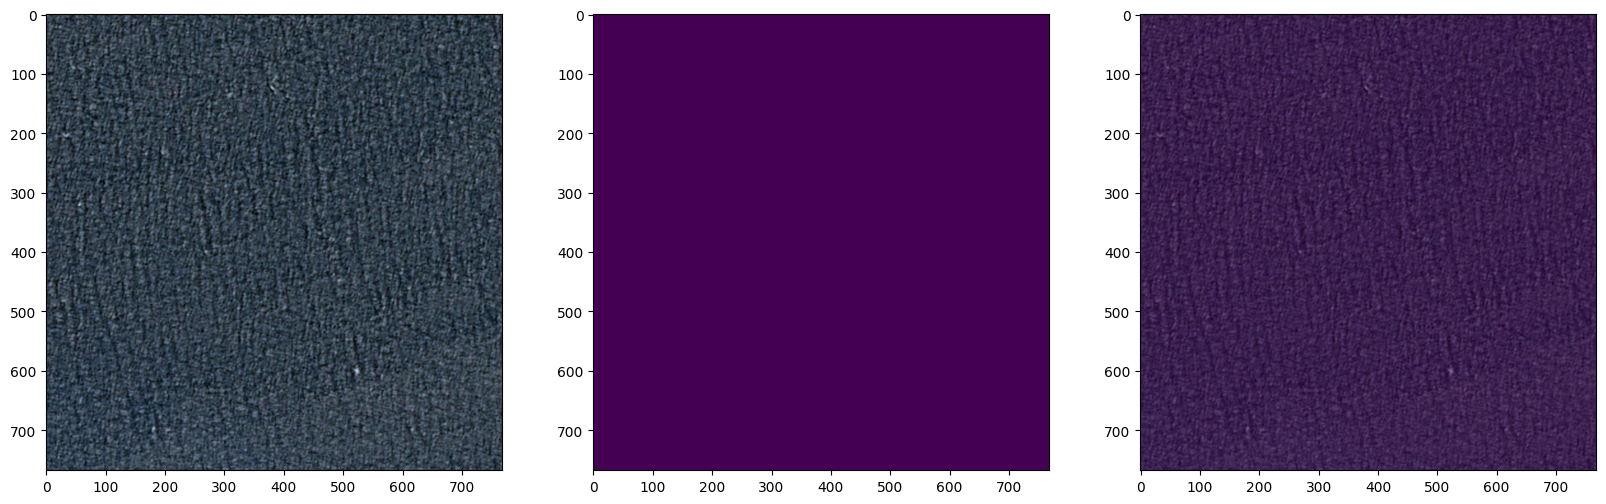

In [11]:
img_id = random.choice(df.index.tolist())
show_img_mask(img_id, df)

In [12]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name="efficientnet-b1",      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    # model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.eval()
    return model

In [13]:
model_path = "/kaggle/input/ship-segmentation/pytorch/default/1/best_epoch-00.bin"

model = load_model(model_path)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [14]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)  # read as BGR by default
    if img is None:
        raise ValueError(f"Image at {path} could not be loaded.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

    img = img.astype('float32')  # convert from uint8 to float32
    mx = np.max(img)
    if mx:
        img /= mx  # scale to [0, 1]
    else:
        print('empty image')
    return img

In [15]:
def preprocess(image):
    raw_image = cv2.resize(image, (224, 224))
    image = np.transpose(raw_image, (2, 0, 1))
    batched_image = np.expand_dims(image, axis=0)
    return raw_image, batched_image

In [16]:
def get_image_mask(img_id):
    img_path = os.path.join(path/'train_v2', img_id)
    print('image-path', img_path)
    image = load_img(img_path)
    image, image_resized = preprocess(image)
    image_pt = torch.from_numpy(image_resized)

    pred = model(image_pt)
    pred = pred.squeeze()
    pred = (nn.Sigmoid()(pred)>0.5).double().numpy()

    return image, pred

image-path /kaggle/input/airbus-ship-detection/train_v2/512146039.jpg


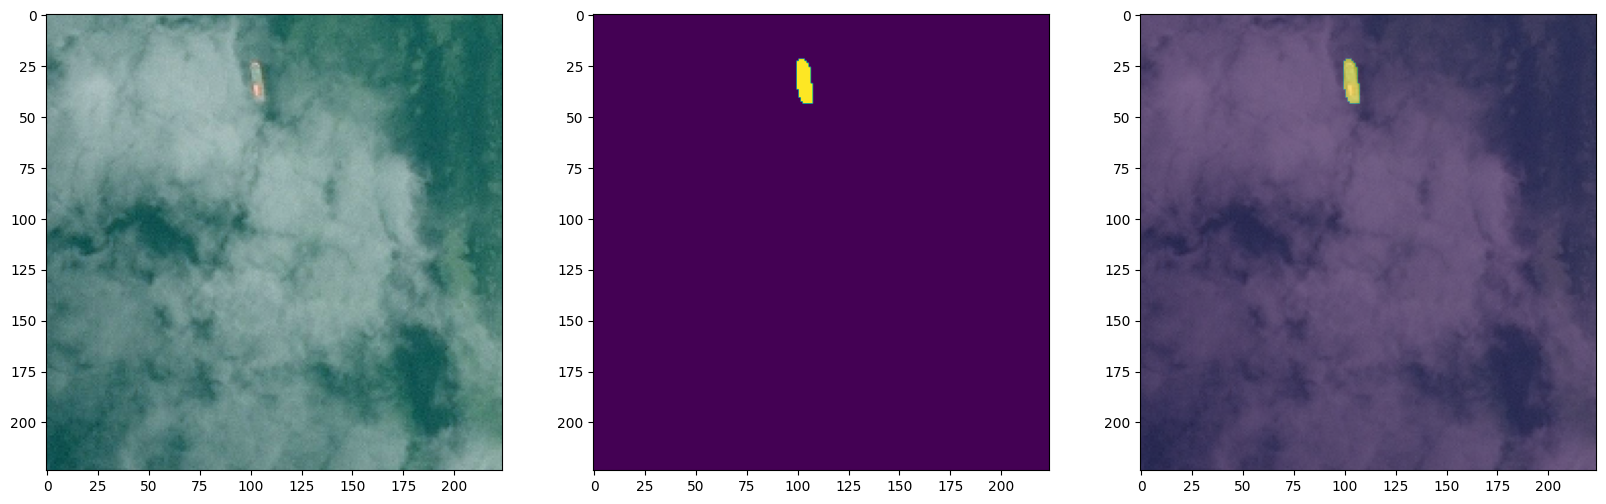

In [17]:
image, pred = get_image_mask("512146039.jpg")
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(pred)

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred, alpha=0.5)
plt.show()

image-path /kaggle/input/airbus-ship-detection/train_v2/4d687d91b.jpg


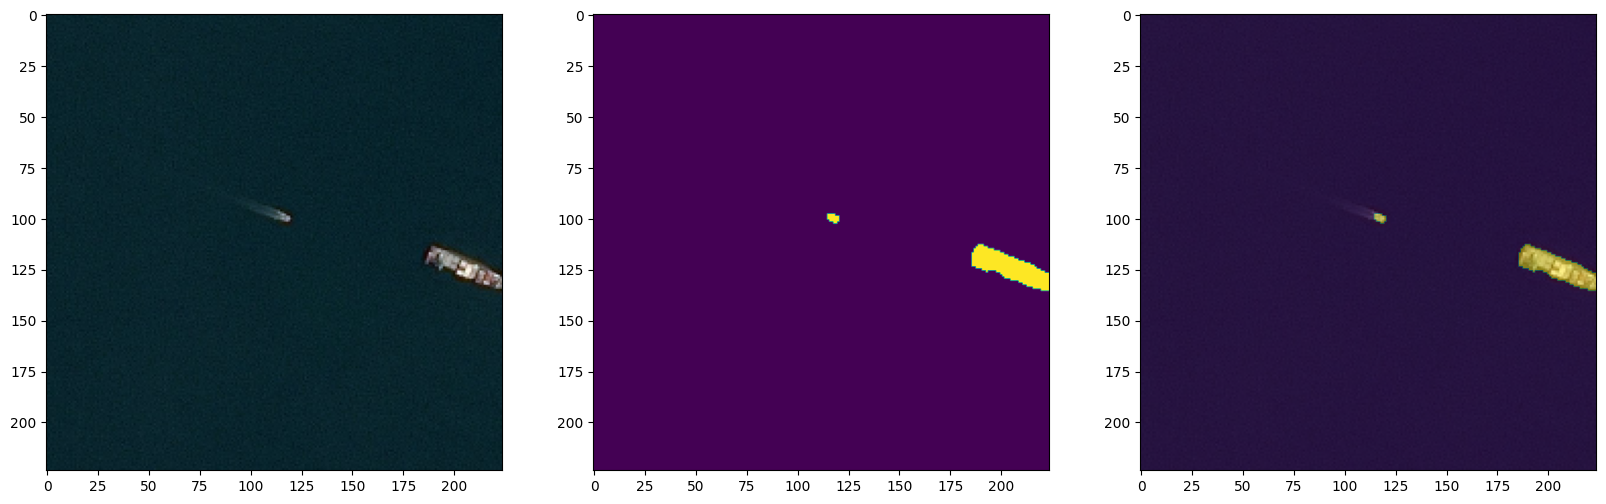

In [18]:
image, pred = get_image_mask("4d687d91b.jpg")
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(pred)

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred, alpha=0.5)
plt.show()

image-path /kaggle/input/airbus-ship-detection/train_v2/1e0382b66.jpg


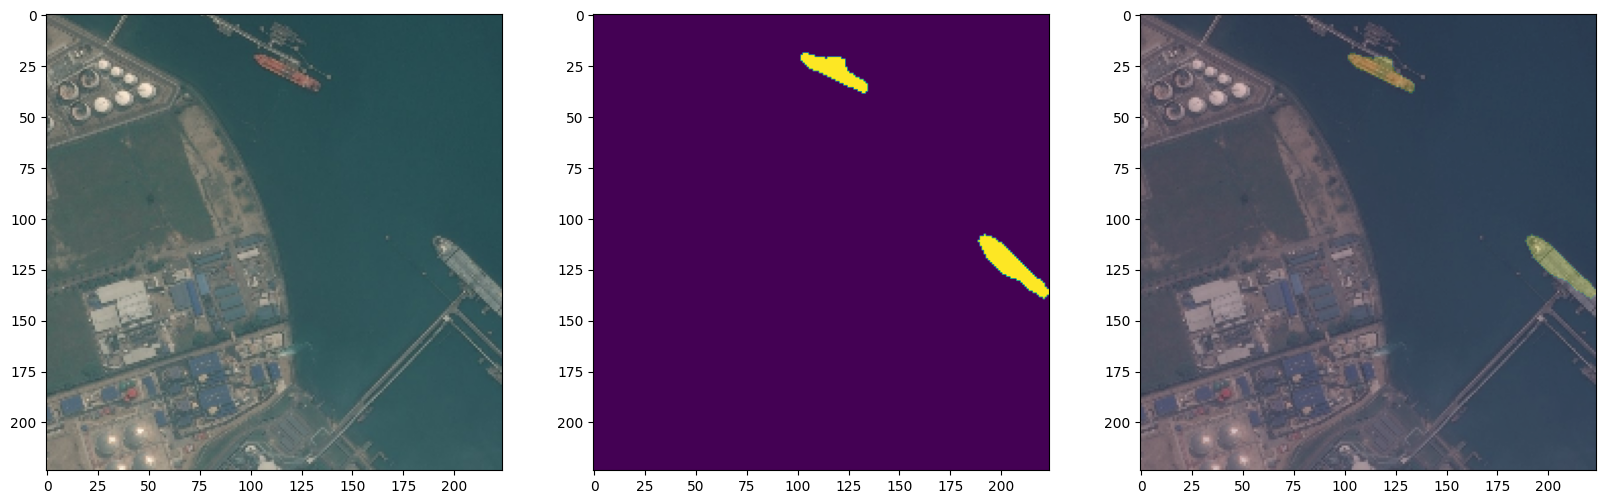

In [19]:
image, pred = get_image_mask("1e0382b66.jpg")
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(pred)

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred, alpha=0.2)
plt.show()

# Predict mask for original image size

In [20]:
def get_image_mask(img_id):
    img_path = os.path.join(path/'train_v2', img_id)
    print('image-path', img_path)
    
    image = load_img(img_path)                      # original image (768x768)
    image_resized, image_tensor = preprocess(image) # resized image (224x224)
    image_pt = torch.from_numpy(image_tensor)

    pred = model(image_pt)
    pred = pred.squeeze().detach().cpu()
    pred = torch.sigmoid(pred).numpy()
    pred = (pred > 0.5).astype(np.uint8)

    # Resize predicted mask back to 768x768
    pred_resized = cv2.resize(pred, (768, 768), interpolation=cv2.INTER_NEAREST)

    return image, pred_resized

image-path /kaggle/input/airbus-ship-detection/train_v2/1e0382b66.jpg


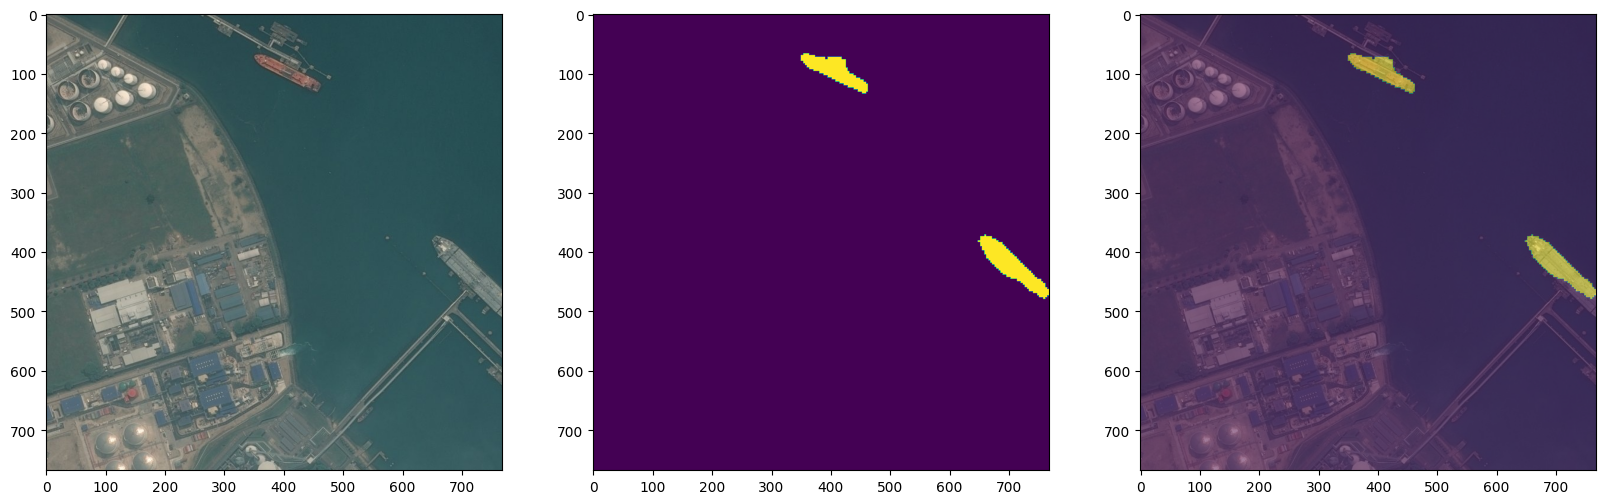

In [21]:
image, pred = get_image_mask("1e0382b66.jpg")

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(pred)

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred, alpha=0.5)
plt.show()

image-path /kaggle/input/airbus-ship-detection/train_v2/bfc7d2b14.jpg


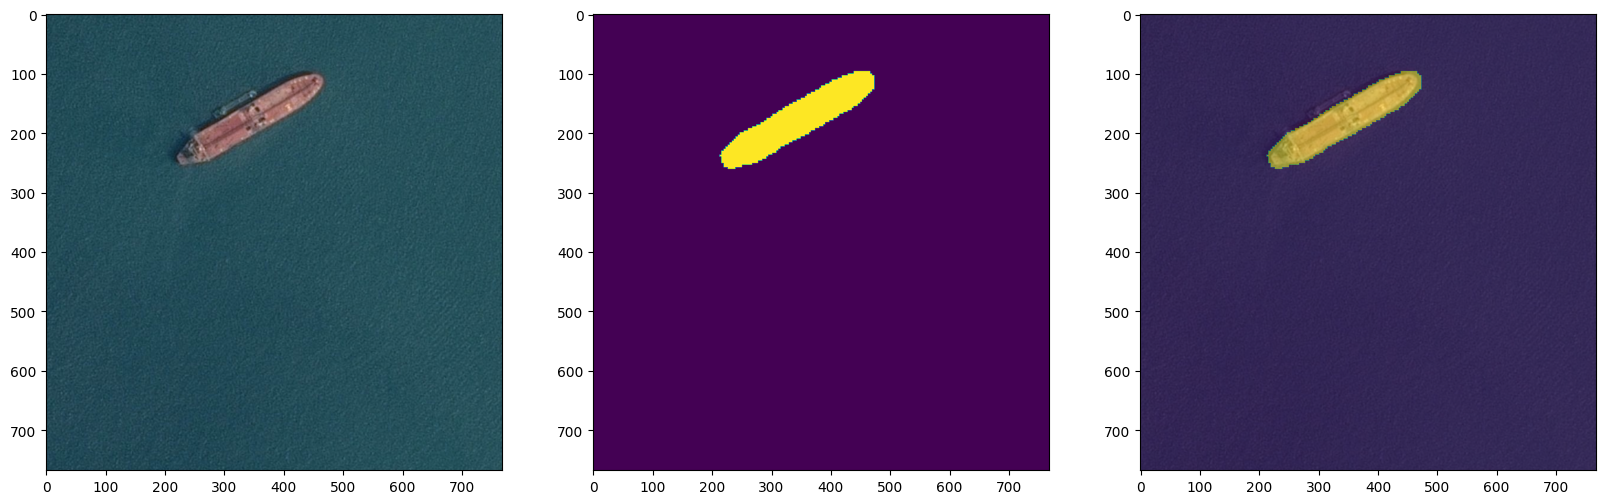

In [23]:
image, pred = get_image_mask("bfc7d2b14.jpg")

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.imshow(pred)

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred, alpha=0.5)
plt.show()